# 🧪 Model Evaluation Notebook

This notebook evaluates multiple models (e.g., baseline, final) using L1, L2, and SSIM metrics.


In [1]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def MAE(imageA, imageB):
    return np.mean(np.abs(imageA.astype("float") - imageB.astype("float")))


def RMSE(imageA, imageB):
    return np.sqrt(np.mean((imageA.astype("float") - imageB.astype("float")) ** 2))


def compute_scores_for_model(result_path, fake_key="fake_B", real_key="real_B"):
    if not os.path.exists(result_path):
        return {"L1": np.nan, "L2": np.nan, "SSIM": np.nan}

    fake_regex = f"_(?P<id>\\d+)_({fake_key})\\.png"
    real_regex = f"_(?P<id>\\d+)_({real_key})\\.png"

    fake_images = {
        f.split("_")[0]: os.path.join(result_path, f)
        for f in os.listdir(result_path)
        if fake_key in f
    }
    real_images = {
        f.split("_")[0]: os.path.join(result_path, f)
        for f in os.listdir(result_path)
        if real_key in f
    }

    pairs = [(fake_images[k], real_images[k]) for k in fake_images if k in real_images]

    l1, l2, ssim_scores = [], [], []
    for fake_path, real_path in pairs:
        fake = cv2.imread(fake_path)
        real = cv2.imread(real_path)
        if fake is None or real is None or fake.shape != real.shape:
            continue
        l1.append(MAE(fake, real))
        l2.append(RMSE(fake, real))
        ssim_scores.append(ssim(fake, real, channel_axis=2))

    if not l1:
        return {"L1": np.nan, "L2": np.nan, "SSIM": np.nan}

    return {"L1": np.mean(l1), "L2": np.mean(l2), "SSIM": np.mean(ssim_scores)}

In [3]:
model_dirs = {
    "gray2real_baseline": "./results/gray2real_baseline/test_300/images",
    "gray2real_final": "./results/gray2real_final/test_300/images",
}

In [4]:
results = []
for model_name, path in model_dirs.items():
    scores = compute_scores_for_model(path)
    results.append({"Model": model_name, **scores})

df = pd.DataFrame(results)
df.set_index("Model", inplace=True)
display(df)

,L1,L2,SSIM
Model,,,
gray2real_baseline,5.898478,9.556523,0.934549
gray2real_final,5.759413,9.326397,0.938898


In [ ]:
# Export the dataframe to an image

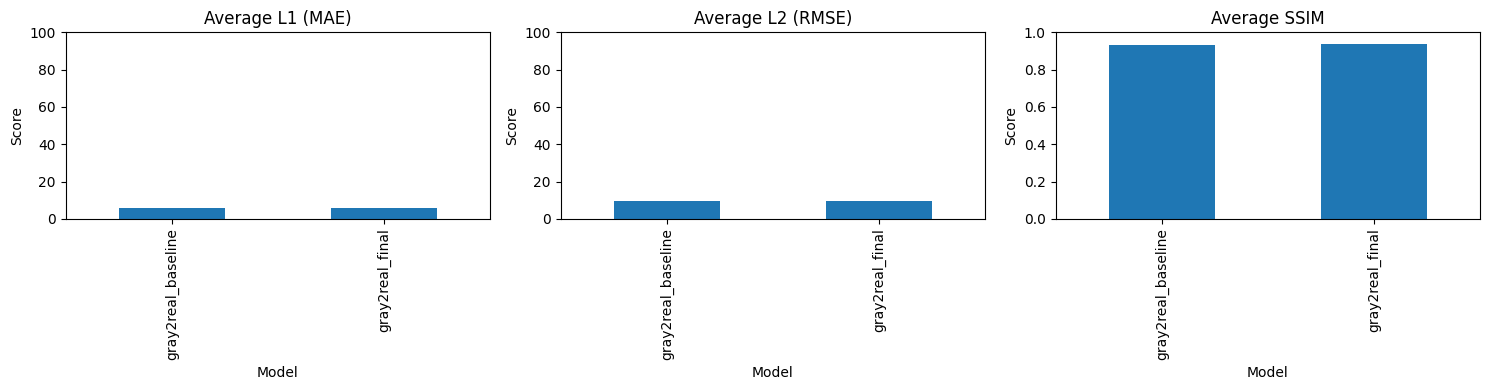

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
df["L1"].plot(kind="bar", ax=ax[0], title="Average L1 (MAE)")
df["L2"].plot(kind="bar", ax=ax[1], title="Average L2 (RMSE)")
df["SSIM"].plot(kind="bar", ax=ax[2], title="Average SSIM")

for axis in ax:
    axis.set_ylabel("Score")
    axis.set_xlabel("Model")
    axis.set_ylim(0, 100 if axis != ax[2] else 1)

plt.tight_layout()
plt.show()


🔍 Visualizing model: gray2real_baseline


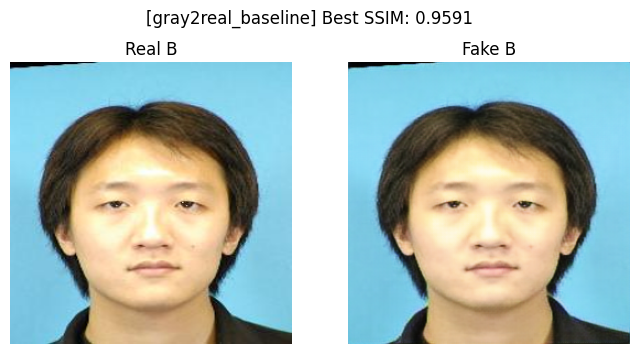

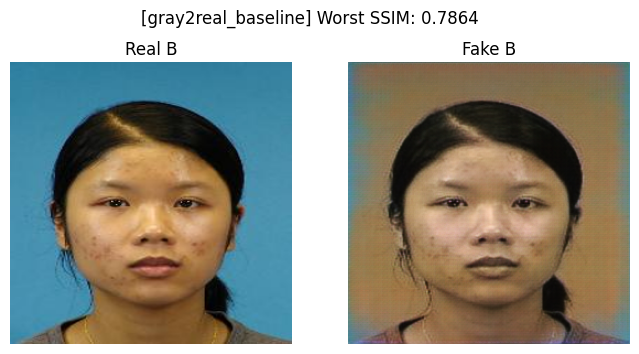

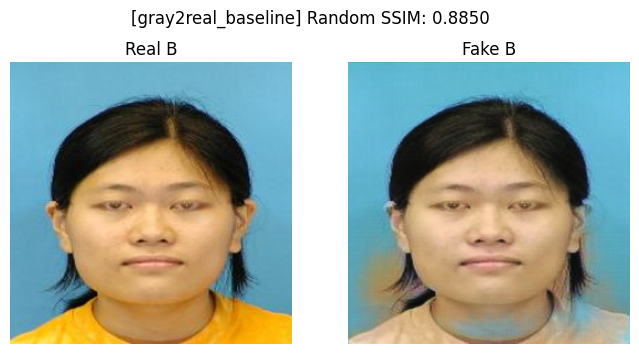


🔍 Visualizing model: gray2real_final


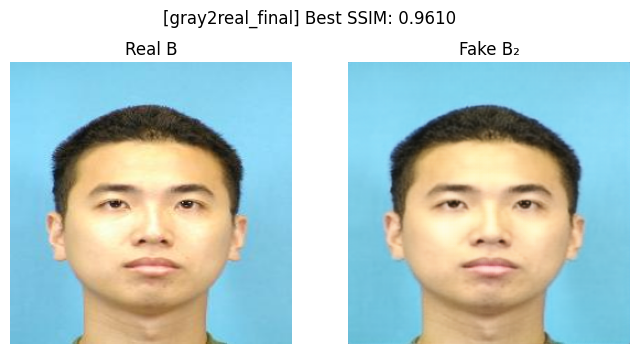

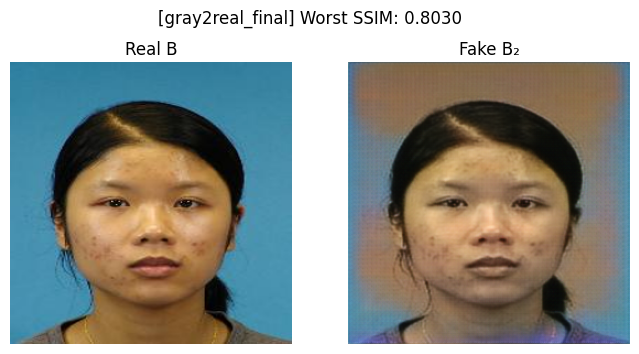

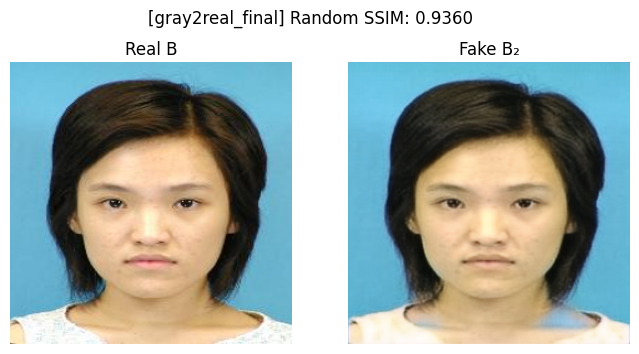

In [20]:
def show_image_pair(
    fake, real, title, fake_label="Fake", idx=None, save_dir="evaluation_samples"
):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(cv2.cvtColor(real, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Real B")
    axs[0].axis("off")
    axs[1].imshow(cv2.cvtColor(fake, cv2.COLOR_BGR2RGB))
    axs[1].set_title(fake_label)
    axs[1].axis("off")
    fig.suptitle(title)
    if idx is not None:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f"{idx}.png"))
    plt.show()


for model_name, path in model_dirs.items():
    print(f"\n🔍 Visualizing model: {model_name}")

    # Use fake_B_2 only for final model
    if "final" in model_name:
        fake_key = "fake_B_2"
        fake_label = "Fake B₂"
    else:
        fake_key = "fake_B"
        fake_label = "Fake B"

    fake_images = {
        f.split("_")[0]: os.path.join(path, f)
        for f in os.listdir(path)
        if fake_key in f
    }
    real_images = {
        f.split("_")[0]: os.path.join(path, f)
        for f in os.listdir(path)
        if "real_B" in f
    }

    common_keys = sorted(set(fake_images) & set(real_images))
    image_pairs = []
    ssims = []

    for key in common_keys:
        fake = cv2.imread(fake_images[key])
        real = cv2.imread(real_images[key])
        if fake is not None and real is not None and fake.shape == real.shape:
            image_pairs.append((fake, real))
            ssims.append(ssim(fake, real, channel_axis=2))

    if not image_pairs:
        print("❌ No valid image pairs found for this model.")
        continue

    best_idx = np.argmax(ssims)
    worst_idx = np.argmin(ssims)
    rand_idx = np.random.randint(len(image_pairs))

    show_image_pair(
        *image_pairs[best_idx],
        title=f"[{model_name}] Best SSIM: {ssims[best_idx]:.4f}",
        fake_label=fake_label,
        idx=f"{model_name}_best",
    )

    show_image_pair(
        *image_pairs[worst_idx],
        title=f"[{model_name}] Worst SSIM: {ssims[worst_idx]:.4f}",
        fake_label=fake_label,
        idx=f"{model_name}_worst",
    )

    show_image_pair(
        *image_pairs[rand_idx],
        title=f"[{model_name}] Random SSIM: {ssims[rand_idx]:.4f}",
        fake_label=fake_label,
        idx=f"{model_name}_random",
    )

In [21]:
for model_name, path in model_dirs.items():
    print(f"\n📊 Generating per-image metrics for: {model_name}")

    # Select fake_B or fake_B_2 depending on model
    fake_key = "fake_B_2" if "final" in model_name else "fake_B"

    # Load image paths
    fake_images = {
        f.split("_")[0]: os.path.join(path, f)
        for f in os.listdir(path)
        if fake_key in f
    }
    real_images = {
        f.split("_")[0]: os.path.join(path, f)
        for f in os.listdir(path)
        if "real_B" in f
    }

    common_keys = sorted(set(fake_images) & set(real_images))
    image_path_pairs = [(fake_images[k], real_images[k]) for k in common_keys]

    l1_distances, l2_distances, ssims = [], [], []
    filenames = []

    for fake_path, real_path in image_path_pairs:
        fake = cv2.imread(fake_path)
        real = cv2.imread(real_path)
        if fake is not None and real is not None and fake.shape == real.shape:
            filenames.append(os.path.basename(fake_path))
            l1_distances.append(MAE(fake, real))
            l2_distances.append(RMSE(fake, real))
            ssims.append(ssim(fake, real, channel_axis=2))

    # Save to CSV
    df = pd.DataFrame(
        {
            "Filename": filenames,
            "L1": l1_distances,
            "L2": l2_distances,
            "SSIM": ssims,
        }
    )

    print(df.head())
    csv_path = f"{model_name}_metrics.csv"
    df.to_csv(csv_path, index=False)
    print(f"📁 Saved: {csv_path}")


📊 Generating per-image metrics for: gray2real_baseline
          Filename        L1         L2      SSIM
0  0000_fake_B.png  4.264414   6.885188  0.944482
1  0001_fake_B.png  4.999298   8.177619  0.945059
2  0002_fake_B.png  8.032842  17.505733  0.928347
3  0003_fake_B.png  3.889150   5.986736  0.945531
4  0004_fake_B.png  4.513153   7.305174  0.941019
📁 Saved: gray2real_baseline_metrics.csv

📊 Generating per-image metrics for: gray2real_final
            Filename        L1         L2      SSIM
0  0000_fake_B_2.png  4.331863   7.143126  0.940190
1  0001_fake_B_2.png  5.241781   8.512262  0.940688
2  0002_fake_B_2.png  8.182068  18.403837  0.928958
3  0003_fake_B_2.png  4.202845   6.309692  0.938674
4  0004_fake_B_2.png  4.399831   7.181970  0.944771
📁 Saved: gray2real_final_metrics.csv
